# Test GEModelTools - HANK-SAM

This notebook shows how to **solve a simple Heterogenous Agent New Keynessian (HANK) model** with **endogenous idiosyncratic risk** using the `GEModelTools` package.

**The steps of the sequence-space solution method are:**

1. Find the stationary equilibrium (steady state for aggregates and distribution).
2. Compute Jacobians of the household block and the full model (to unknowns and shocks)
3. Find the non-linear transition path or the linearized impulse responses to a given shock path.
4. Simulate the linearized model with aggregate risk

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from HANKSAMModel import HANKSAMModelClass

# Setup

In [2]:
model = HANKSAMModelClass(name='baseline')

In [3]:
#model.print_unpack_varlist()

In [4]:
#print(model)

# Steady state

In [5]:
model.find_ss(do_print=True)

household problem in ss solved in 4.2 secs [1505 iterations]
household problem in ss simulated in 5.0 secs [1358 iterations]
GDP by spending: C = 0.699, G = 0.301
Implied B =  4.860
Discrepancy in C =   0.00000000
Implied nu =  1.243


In [6]:
par = model.par
ss = model.ss
path = model.path

**Productivity states:**

In [7]:
for i_fix in range(par.Nfix):
    
    beta = par.beta_grid[i_fix]
    print(f'{beta = :.4f}:')
    
    for z,pr_z in zip(par.z_grid,ss.Dz[i_fix]/np.sum(ss.Dz[i_fix])):
        print(f' Pr[z = {z:.4f}] = {pr_z:.4f}')

beta = 0.9797:
 Pr[z = 0.3539] = 0.0180
 Pr[z = 0.4874] = 0.0863
 Pr[z = 0.6714] = 0.2209
 Pr[z = 0.9249] = 0.3022
 Pr[z = 1.2740] = 0.2209
 Pr[z = 1.7549] = 0.0863
 Pr[z = 2.4173] = 0.0180
 Pr[z = 0.3539] = 0.0009
 Pr[z = 0.4874] = 0.0043
 Pr[z = 0.6714] = 0.0110
 Pr[z = 0.9249] = 0.0151
 Pr[z = 1.2740] = 0.0110
 Pr[z = 1.7549] = 0.0043
 Pr[z = 2.4173] = 0.0009
beta = 0.9897:
 Pr[z = 0.3539] = 0.0180
 Pr[z = 0.4874] = 0.0863
 Pr[z = 0.6714] = 0.2209
 Pr[z = 0.9249] = 0.3022
 Pr[z = 1.2740] = 0.2209
 Pr[z = 1.7549] = 0.0863
 Pr[z = 2.4173] = 0.0180
 Pr[z = 0.3539] = 0.0009
 Pr[z = 0.4874] = 0.0043
 Pr[z = 0.6714] = 0.0110
 Pr[z = 0.9249] = 0.0151
 Pr[z = 1.2740] = 0.0110
 Pr[z = 1.7549] = 0.0043
 Pr[z = 2.4173] = 0.0009


## Policy functions

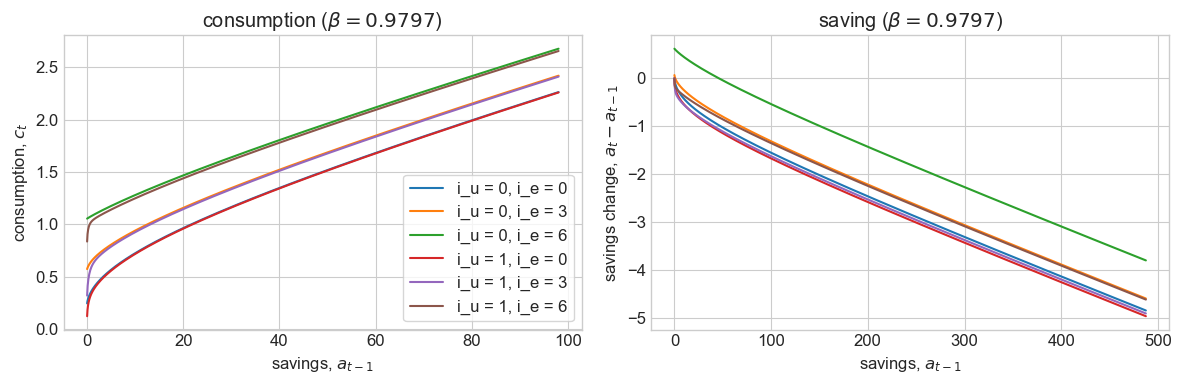

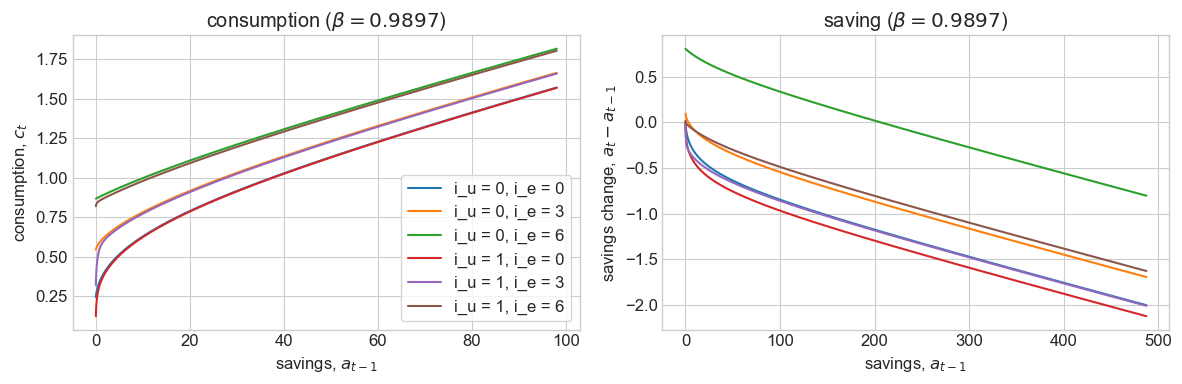

In [8]:
c = ss.c.reshape((par.Nbeta,2,par.Ne,par.Na))
a = ss.a.reshape((par.Nbeta,2,par.Ne,par.Na))

for i_beta,beta in enumerate(par.beta_grid):
    
    fig = plt.figure(figsize=(12,4),dpi=100)

    # a. consumption
    I = par.a_grid < 100
    
    ax = fig.add_subplot(1,2,1)
    ax.set_title(f'consumption ($\\beta = {beta:.4f}$)')

    for i_u in range(2):
        for i_e in [0,par.Ne//2,par.Ne-1]:
            ax.plot(par.a_grid[I],c[i_beta,i_u,i_e,I],label=f'i_u = {i_u}, i_e = {i_e}')

    ax.legend(frameon=True)
    ax.set_xlabel('savings, $a_{t-1}$')
    ax.set_ylabel('consumption, $c_t$')
    
    # b. saving
    I = par.a_grid < 500
    
    ax = fig.add_subplot(1,2,2)
    ax.set_title(f'saving ($\\beta = {beta:.4f}$)')

    for i_u in range(2):
        for i_e in [0,par.Ne//2,par.Ne-1]:
            ax.plot(par.a_grid[I],a[i_beta,i_u,i_e,I]-par.a_grid[I],label=f'i_u = {i_u}, i_e = {i_e}')

    ax.set_xlabel('savings, $a_{t-1}$')
    ax.set_ylabel('savings change, $a_{t}-a_{t-1}$')
    
    fig.tight_layout()

## Simulation

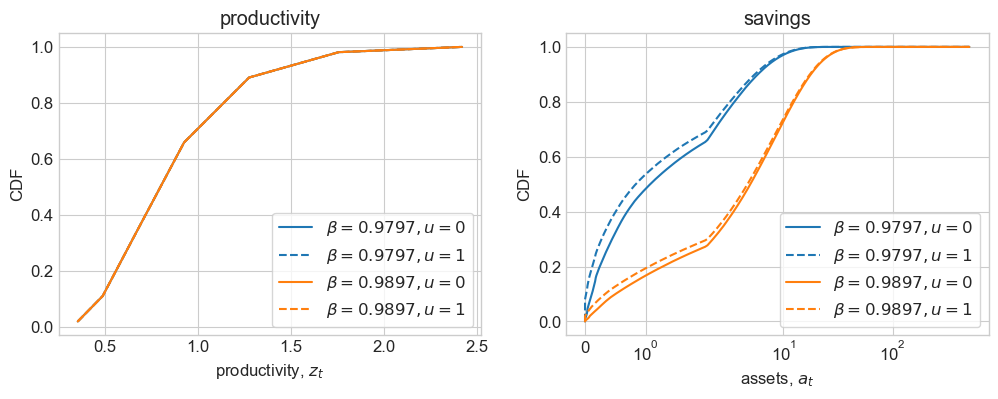

In [9]:
fig = plt.figure(figsize=(12,4),dpi=100)

# a. income
z_grid = par.z_grid.reshape((2,par.Ne))
D = ss.D.reshape((par.Nbeta,2,par.Ne,par.Na))

ax = fig.add_subplot(1,2,1)
ax.set_title('productivity')

for i_beta in range(par.Nbeta):
    for i_u in range(2):
        ls = '-' if i_u == 0 else '--'
        label = fr'$\beta = {par.beta_grid[i_beta]:.4f}, u = {i_u}$'
        y = np.cumsum(np.sum(D[i_beta,i_u],axis=1))
        ax.plot(z_grid[i_u],y/y[-1],color=colors[i_beta],ls=ls,label=label)

ax.set_xlabel('productivity, $z_{t}$')
ax.set_ylabel('CDF')
ax.legend(frameon=True)

# b. assets
ax = fig.add_subplot(1,2,2)
ax.set_title('savings')
for i_beta in range(par.Nbeta):
    for i_u in range(2):
        ls = '-' if i_u == 0 else '--'
        label = fr'$\beta = {par.beta_grid[i_beta]:.4f}, u = {i_u}$'
        y = np.insert(np.cumsum(np.sum(D[i_beta,i_u],axis=0)),0,0.0)
        ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),y/y[-1],color=colors[i_beta],ls=ls,label=label)
        
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')
ax.legend(frameon=True);

**Asset moments:**

In [10]:
# a. prepare
Da = np.sum(ss.D,axis=(0,1))
Da_cs = np.cumsum(Da)
mean_a = np.sum(Da*par.a_grid)
std_a = np.sqrt(np.sum(Da*(par.a_grid-mean_a)**2))

def percentile(par,Da_cs,p):
    
    # a. check first
    if p < Da_cs[0]: return par.a_grid[0]
    
    # b. find with loop
    i = 0
    while True:
        if p > Da_cs[i+1]:
            if i+1 >= par.Na: raise Exception()
            i += 1
            continue
        else:
            w = (p-Da_cs[i])/(Da_cs[i+1]-Da_cs[i])
            diff = par.a_grid[i+1]-par.a_grid[i]
            return par.a_grid[i]+w*diff
        
p25_a = percentile(par,Da_cs,0.25)
p50_a = percentile(par,Da_cs,0.50)
p95_a = percentile(par,Da_cs,0.95)
p99_a = percentile(par,Da_cs,0.99)

# b. print
print(f'mean a: {mean_a:6.3f}')
print(f'p25  a: {p25_a:6.3f}')
print(f'p50  a: {p50_a:6.3f}')
print(f'p95  a: {p95_a:6.3f}')
print(f'p99  a: {p99_a:6.3f}')
print(f'std. a: {std_a:6.3f}')

mean a:  4.860
p25  a:  0.628
p50  a:  2.314
p95  a: 17.967
p99  a: 29.192
std. a:  6.382


**MPC:**

In [11]:
MPC = np.zeros(ss.D.shape)
m_diff = (1+ss.r)*par.a_grid[np.newaxis,np.newaxis,1:]-(1+model.ss.r)*par.a_grid[np.newaxis,np.newaxis,:-1]
MPC[:,:,:-1] = (ss.c[:,:,1:]-ss.c[:,:,:-1])/m_diff
MPC[:,:,-1] = MPC[:,:,-1] # assuming constant MPC at end
mean_MPC = np.sum(MPC*ss.D)
mean_MPC_ann = 1-(1-mean_MPC)**4
print(f'mean MPC: {mean_MPC:.3f} [annual: {mean_MPC_ann:.3f}]')

mean MPC: 0.058 [annual: 0.212]


# Tests

**Household transition path:**

note: inputs = steady state value -> expected: constant value (straigt line)

household z z simulated along transition in 2.2 secs



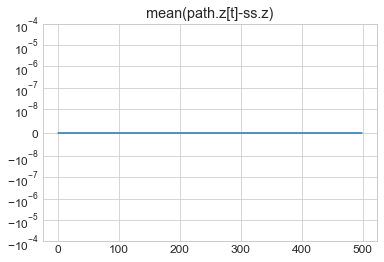

In [12]:
model.test_hh_z_path()

note: inputs = steady state value -> expected: constant value (straigt line)

household problem solved along transition path in 1.1 secs
household problem simulated along transition in 1.7 secs



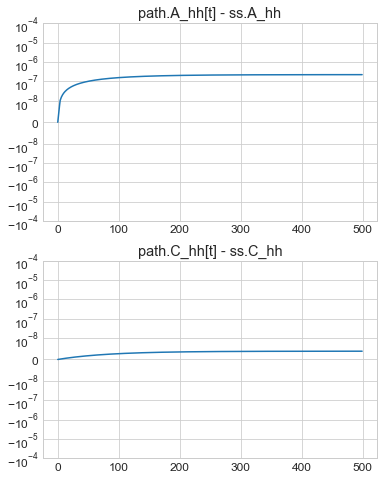

In [13]:
model.test_hh_path()

**Full transition path:**

In [14]:
model.test_path()

note: inputs = steady state value -> expected: no difference to steady state and zero errors

difference to value at steady state:
A_hh           : t0 =  2.7e-15, max abs.  2.2e-07
A              : t0 =  8.9e-16, max abs.  4.6e-14
B              : t0 =  8.9e-16, max abs.  4.6e-14
C_hh           : t0 = -2.2e-15, max abs.  3.8e-09
C              : t0 =  0.0e+00, max abs.  0.0e+00
d              : t0 =  0.0e+00, max abs.  0.0e+00
EU             : t0 =  0.0e+00, max abs.  0.0e+00
G              : t0 =  0.0e+00, max abs.  0.0e+00
Z              : t0 =  0.0e+00, max abs.  0.0e+00
i              : t0 =  0.0e+00, max abs.  0.0e+00
N              : t0 =  0.0e+00, max abs.  0.0e+00
Pi_w           : t0 =  0.0e+00, max abs.  0.0e+00
Pi             : t0 =  0.0e+00, max abs.  0.0e+00
r              : t0 =  0.0e+00, max abs.  0.0e+00
rh             : t0 =  0.0e+00, max abs.  0.0e+00
tau            : t0 =  0.0e+00, max abs.  1.3e-15
U              : t0 =  0.0e+00, max abs.  0.0e+00
UE             : t0

**Calculation of Jacobians:**

In [15]:
par.varepsilon_U = 5.0

note: differences should only be due to numerical errors

direct method:
finding Jacobian wrt. ghost          : 0 150 300 [computed in 1.4 secs]
finding Jacobian wrt. EU             : 0 150 300 [computed in 1.5 secs]
finding Jacobian wrt. UE             : 0 150 300 [computed in 1.4 secs]
finding Jacobian wrt. rh             : 0 150 300 [computed in 1.6 secs]
finding Jacobian wrt. wh             : 0 150 300 [computed in 1.4 secs]
household Jacobian computed in 7.4 secs

fake news method:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for EU              in 1.1 secs
curly_Y and curly_D calculated for UE              in 1.0 secs
curly_Y and curly_D calculated for rh              in 1.0 secs
curly_Y and curly_D calculated for wh              in 1.0 secs
curly_E calculated in 2.1 secs
builiding blocks combined in 0.4 secs
household Jacobian computed in 6.6 secs

A_hh:
 EU             : cond = 1.1e+02 [mean =  5.7e-03]
 UE             : cond = 1.1e

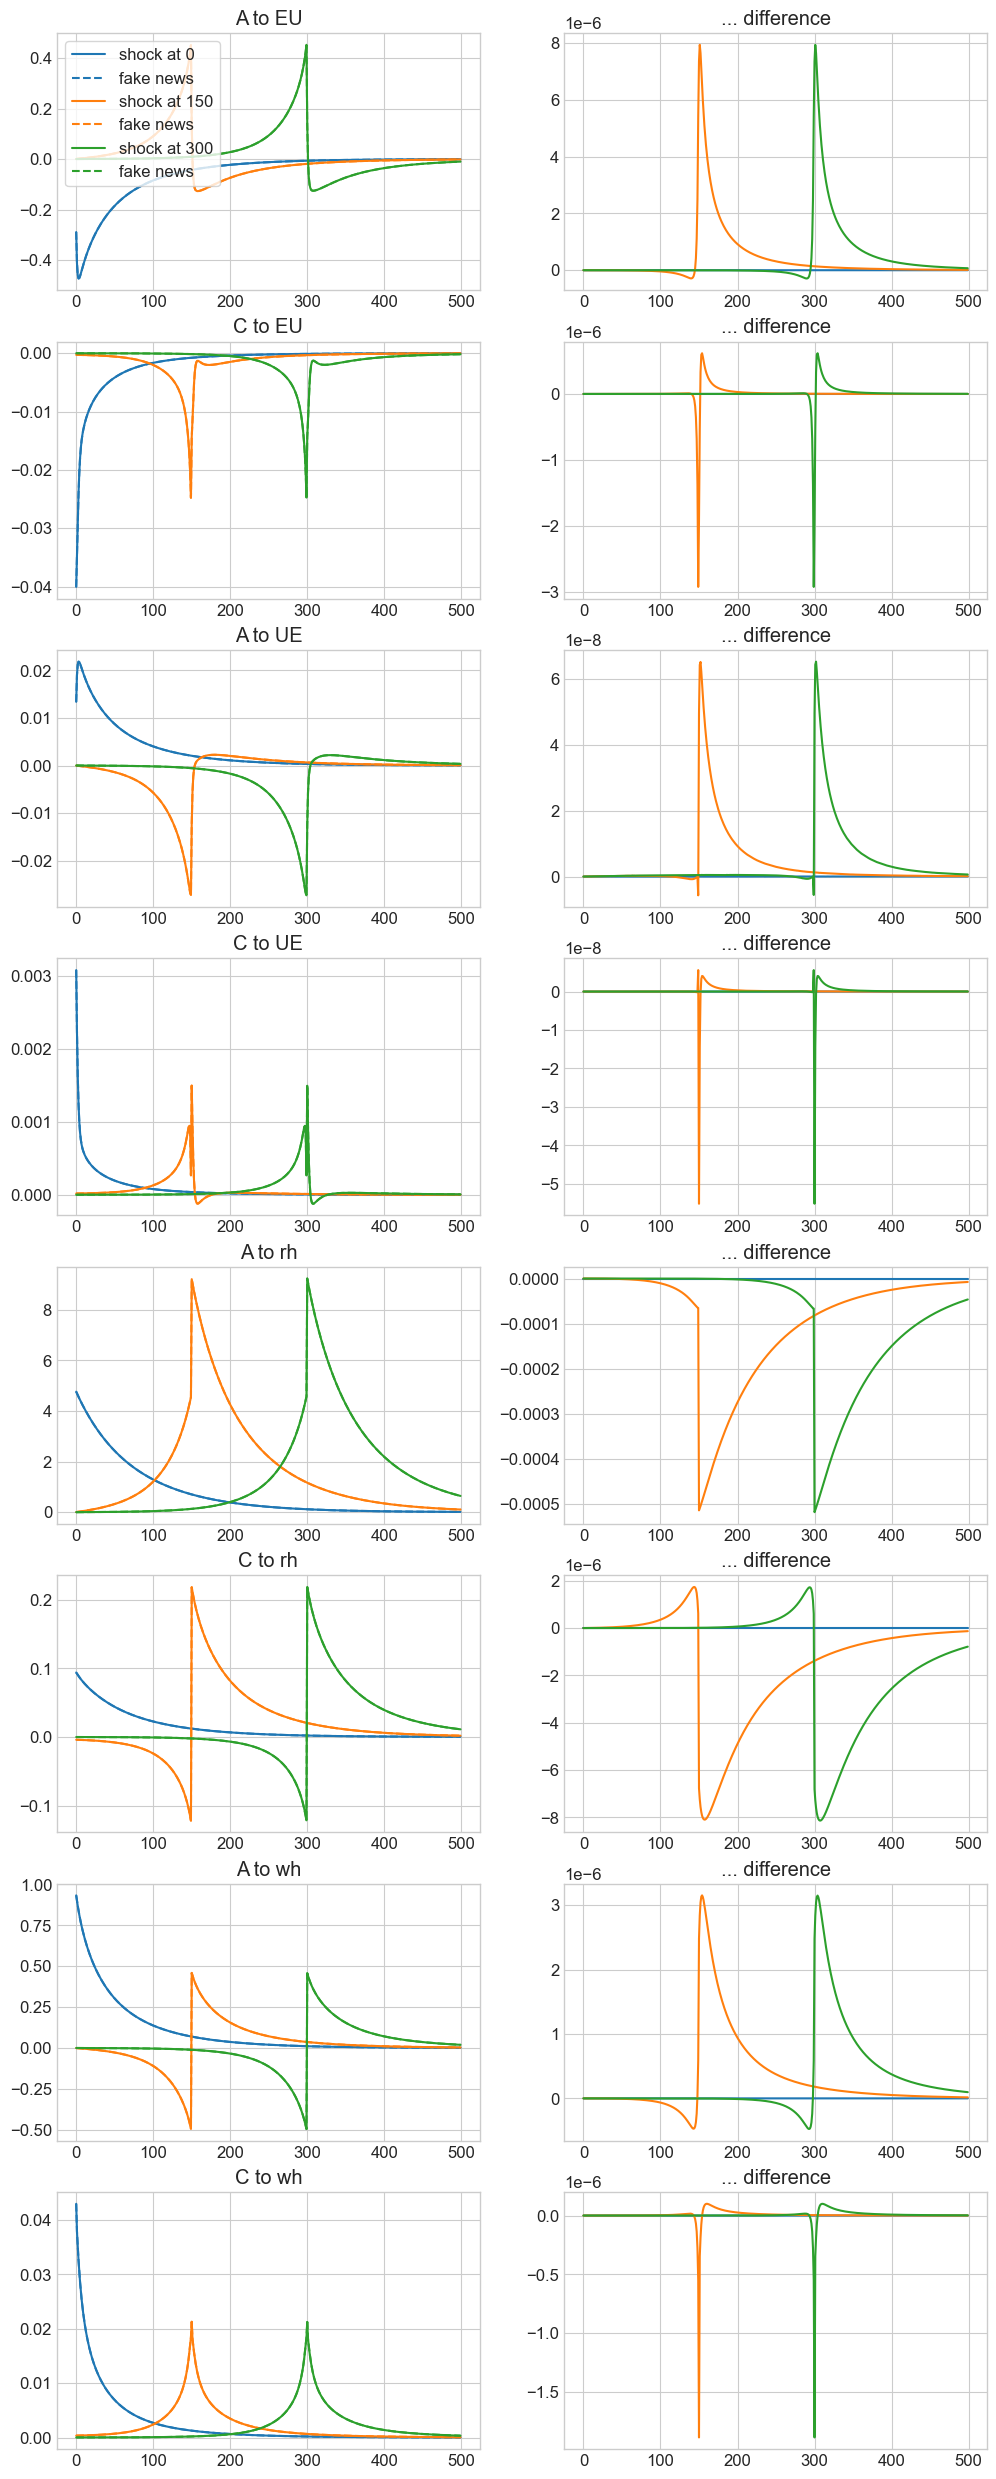

In [16]:
s_list = [0,150,300]
model.test_jac(s_list)

# Jacobian of household problem at steady state

In [17]:
model.compute_jacs(do_print=True)

household Jacobians:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for EU              in 1.0 secs
curly_Y and curly_D calculated for UE              in 1.0 secs
curly_Y and curly_D calculated for rh              in 0.9 secs
curly_Y and curly_D calculated for wh              in 0.9 secs
curly_E calculated in 0.3 secs
builiding blocks combined in 0.4 secs
household Jacobian computed in 4.5 secs

full Jacobians:
full Jacobian to unknowns computed in 0.9 secs [in evaluate_path(): 0.5 secs]
full Jacobian to shocks computed in 0.9 secs [in evaluate_path(): 0.5 secs]


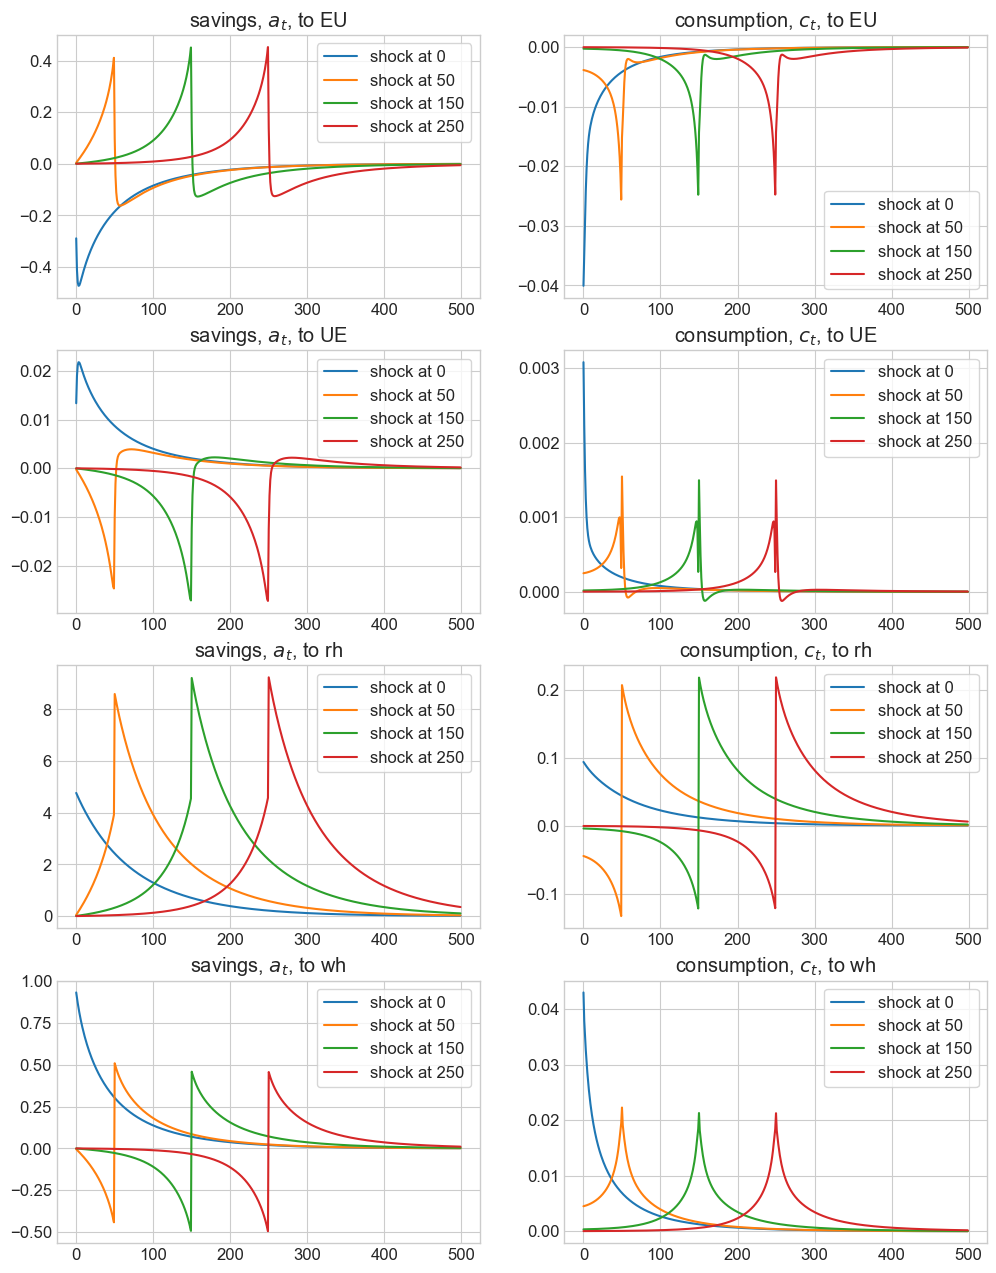

In [18]:
fig = plt.figure(figsize=(12,len(model.inputs_hh_all)*4),dpi=100)

i = 0
for varname in model.inputs_hh_all:
    
    # a. savings
    i += 1    
    ax = fig.add_subplot(len(model.inputs_hh_all),2,i)
    ax.set_title(f'savings, $a_t$, to {varname}')
    for s in [0,50,150,250]:
        jac_hh_var = model.jac_hh[('A_hh',varname)]
        ax.plot(np.arange(par.T),jac_hh_var[:,s],label=f'shock at {s}')
    ax.legend(frameon=True)

    # b. consumption
    i += 1    
    ax = fig.add_subplot(len(model.inputs_hh_all),2,i)
    ax.set_title(f'consumption, $c_t$, to {varname}')
    for s in [0,50,150,250]:
        jac_hh_var = model.jac_hh[('C_hh',varname)]
        ax.plot(np.arange(par.T),jac_hh_var[:,s],label=f'shock at {s}')
    ax.legend(frameon=True)
    

# Transition path

## Find transition path

**Compute full Jacobian at steady state:**

**Find transition paths:**

In [19]:
model.find_transition_path(do_print=True)

finding the transition path:
 it =   0 -> max. abs. error = 1.73e-01
   1.73e-01 in WPC
   4.32e-02 in clearing_A
 it =   1 -> max. abs. error = 2.36e-03
   2.36e-03 in WPC
   2.60e-05 in clearing_A
 it =   2 -> max. abs. error = 2.63e-05
   2.63e-05 in WPC
   5.86e-07 in clearing_A
 it =   3 -> max. abs. error = 2.67e-07
   2.67e-07 in WPC
   2.50e-09 in clearing_A
 it =   4 -> max. abs. error = 6.43e-09
   6.43e-09 in WPC
   6.82e-12 in clearing_A

transition path found in 6.1 secs


## Plot transitions

### shocks ###


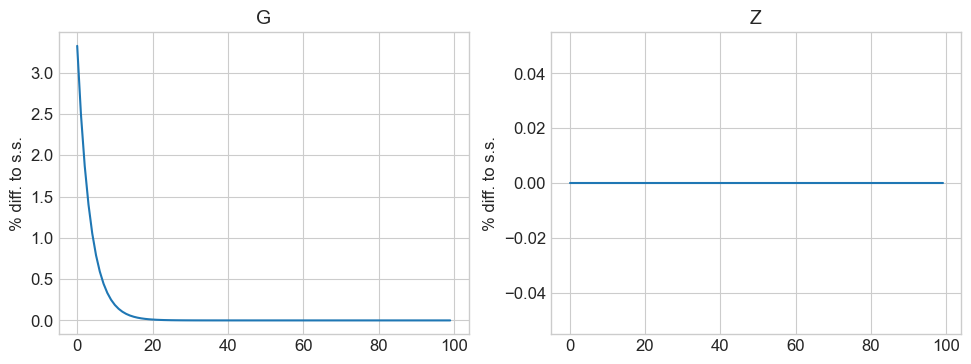


### varnames ###


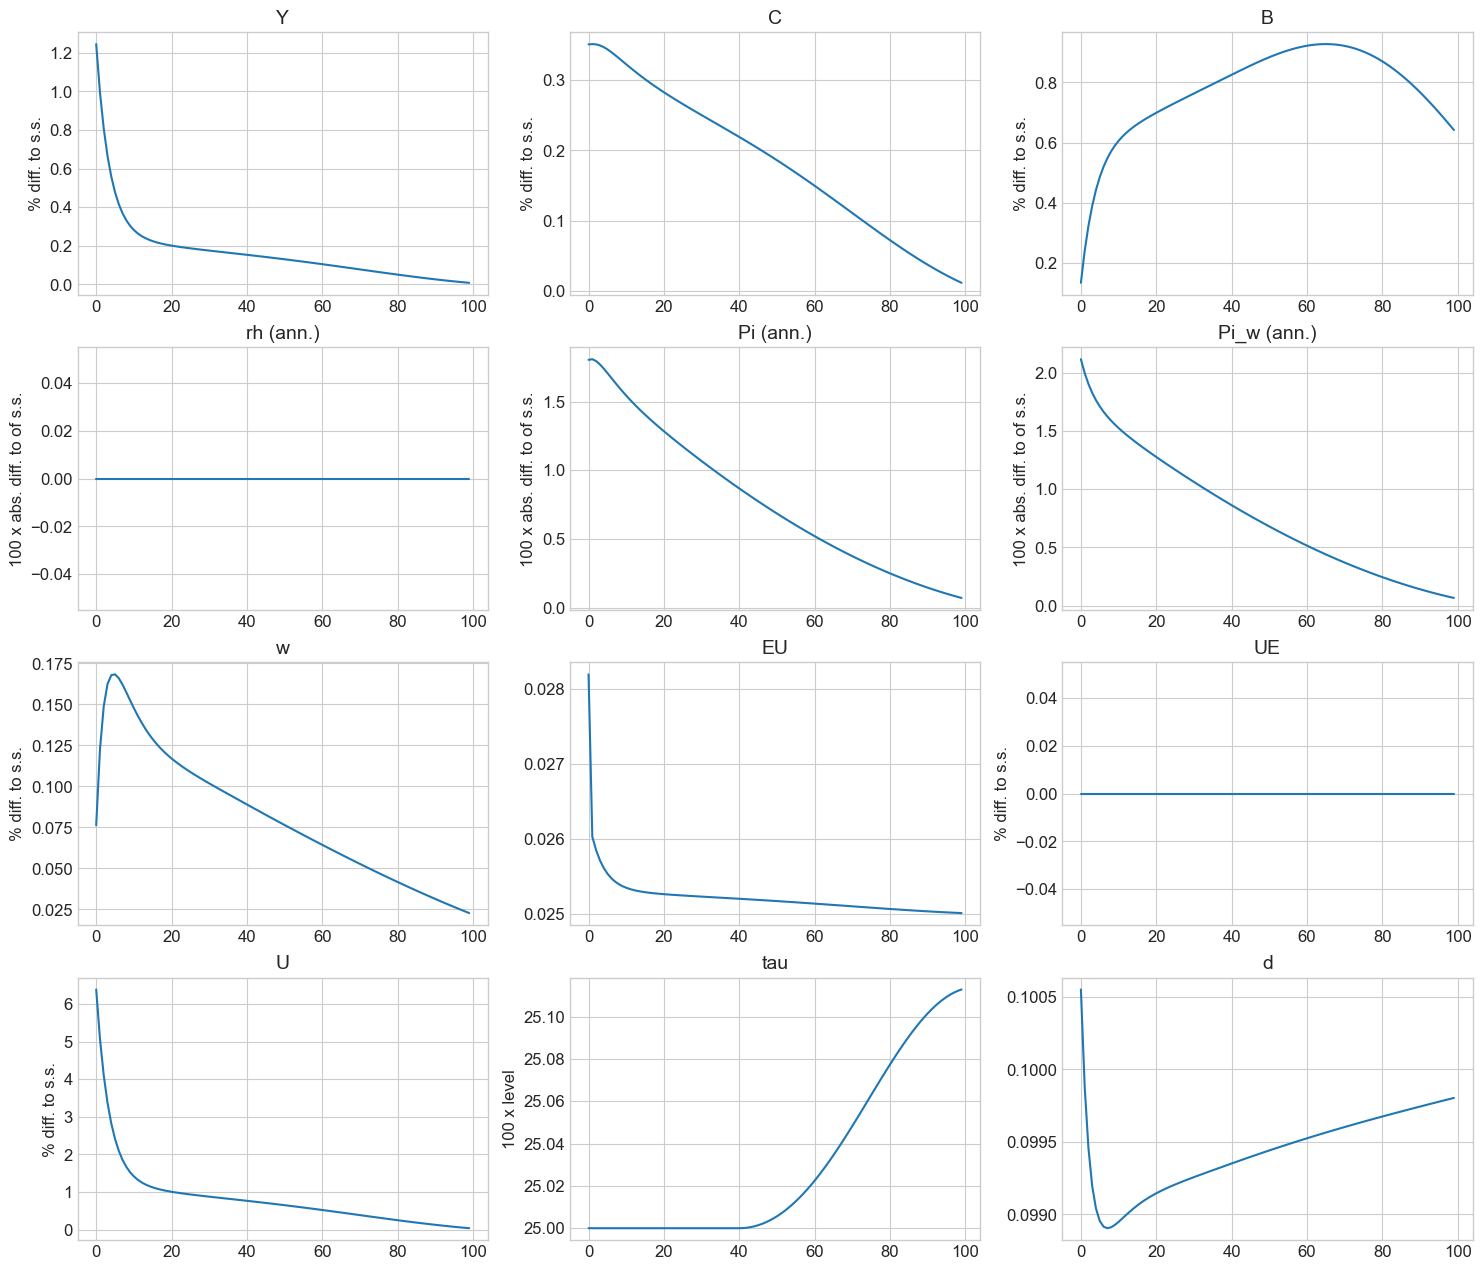


### tagets ###


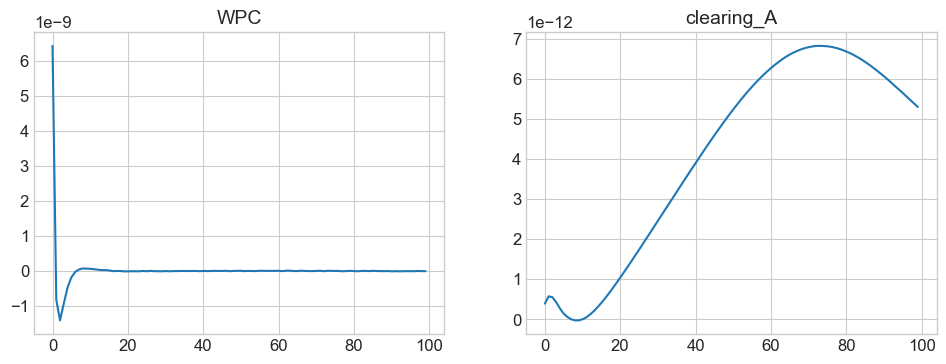

In [20]:
paths = ['Y','C','B','rh','Pi','Pi_w','w','EU','UE','U','tau','d']
abs_diff = ['rh','Pi','Pi_w']
lvl_value = ['tau','d','EU']
facs = {'rh':100,'Pi':100,'Pi_w':100,'tau':100}
pows = {'rh':4,'Pi':4,'Pi_w':4}
model.show_IRFs(paths,abs_diff=abs_diff,lvl_value=lvl_value,facs=facs,pows=pows,T_max=100,ncols=3)

## Linearized

In [21]:
model.find_IRFs(do_print=True)

linear transition path found in 0.1 secs [finding solution matrix: 0.1 secs]


### shocks ###


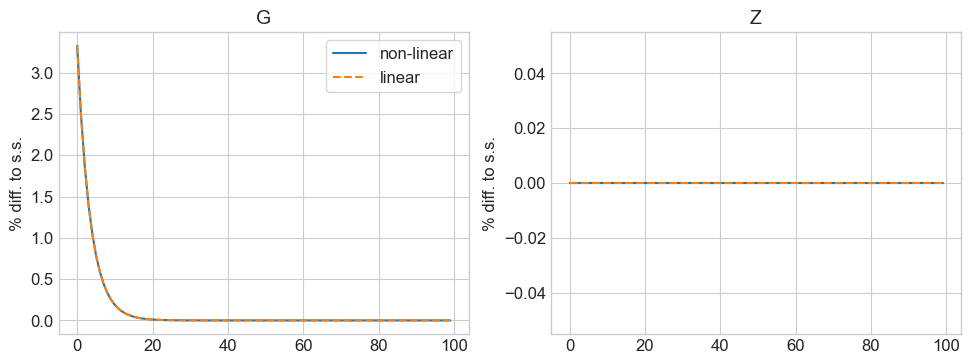


### varnames ###


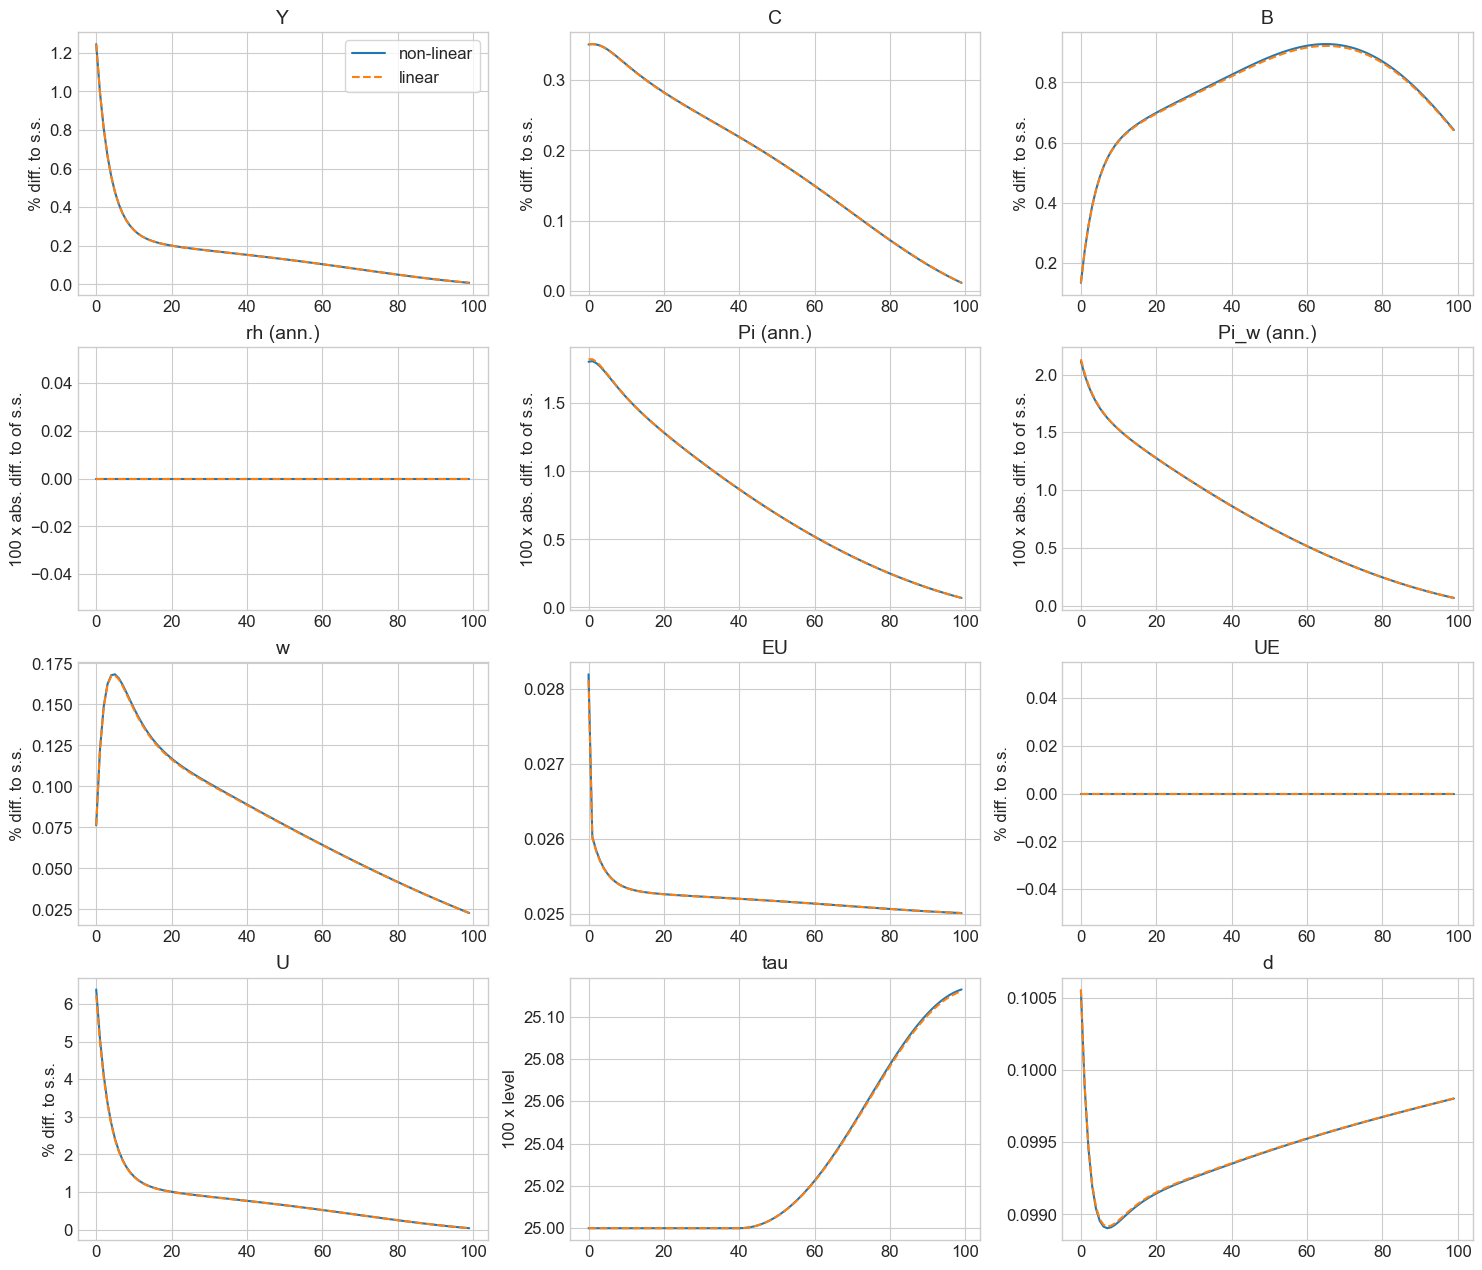


### tagets ###


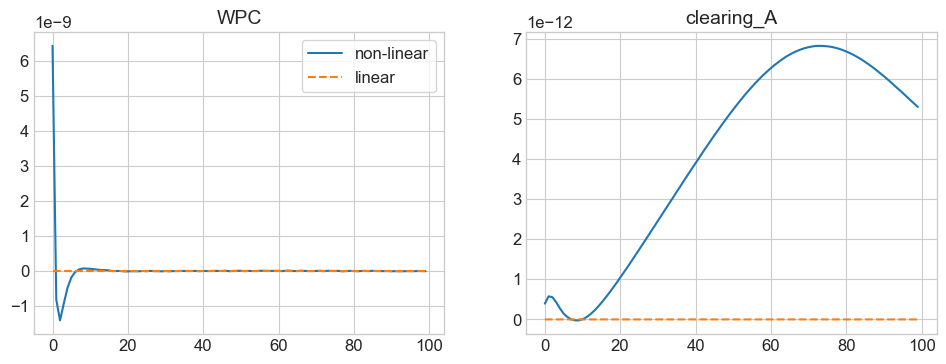

In [22]:
model.show_IRFs(paths,abs_diff=abs_diff,lvl_value=lvl_value,facs=facs,pows=pows,T_max=100,ncols=3,do_linear=True)